In [13]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#  Parámetros HOG óptimos
hog_params = {
    "orientations": 12,
    "pixels_per_cell": (8, 8),
    "cells_per_block": (2, 2),
    "block_norm": "L2-Hys"
}

In [3]:
#  Rutas del dataset
dataset_path = "/content/drive/MyDrive/lbp_aumentado"
categories = ["ganado", "radioactividad","negativo"]

In [4]:
#  Cargar imágenes con procesamiento HOG optimizado
def load_images_and_labels(dataset_path, categories, max_images=None):
    data, labels = [], []
    for label, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        images = os.listdir(category_path)

        if max_images:
            images = images[:max_images]  # Limitar el número de imágenes para acelerar entrenamiento

        for filename in tqdm(images, desc=f"Procesando {category}"):
            img_path = os.path.join(category_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            if img is None:
                continue  # Saltar imágenes corruptas

            img = cv2.resize(img, (64, 64))  # Redimensionar
            features = hog(img, **hog_params)  # Extraer HOG

            data.append(features)
            labels.append(label)

    return np.array(data), np.array(labels)

In [7]:
#  Cargar imágenes y extraer características HOG
X, y = load_images_and_labels(dataset_path, categories)
print(f"Total de imágenes cargadas: {len(y)}")

Procesando negativo: 100%|██████████| 4095/4095 [03:46<00:00, 18.11it/s]


Total de imágenes cargadas: 8187


In [8]:
#  Separar datos en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
svm = SVC(C=1, kernel="rbf", gamma="scale")

In [10]:
svm.fit(X_train, y_train)

SVC(C=1)

In [18]:
#  Evaluar modelo
y_pred = svm.predict(X_test)
print("\n Accuracy Final:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))



 Accuracy Final: 0.9761904761904762
              precision    recall  f1-score   support

           0       0.98      0.93      0.96       436
           1       0.99      0.98      0.99       390
           2       0.97      1.00      0.98       812

    accuracy                           0.98      1638
   macro avg       0.98      0.97      0.97      1638
weighted avg       0.98      0.98      0.98      1638



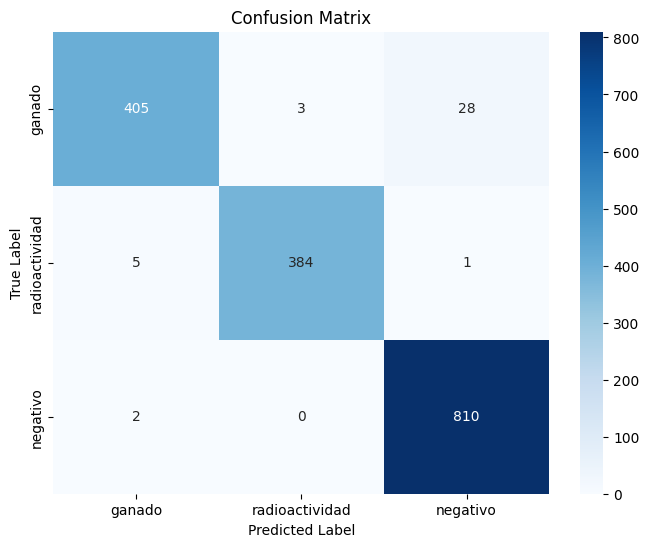

In [14]:
# 🔹 Generar matriz de confusión
cm = confusion_matrix(y_test, y_pred)
labels = np.unique(y_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [16]:
#  Guardar el modelo entrenado para usarlo después
import joblib
joblib.dump(svm, "modelo_svm_hog5.pkl")
print("\n Modelo SVM guardado como 'modelo_svm_hog5.pkl'")


 Modelo SVM guardado como 'modelo_svm_hog5.pkl'


In [17]:
import os
import cv2
import numpy as np
from skimage.feature import hog
import joblib

#  Cargar el modelo SVM entrenado
svm = joblib.load("modelo_svm_hog5.pkl")

#  Parámetros HOG (deben ser los mismos usados en el entrenamiento)
hog_params = {
    "orientations": 12,
    "pixels_per_cell": (8, 8),
    "cells_per_block": (2, 2),
    "block_norm": "L2-Hys"
}

#  Función para preprocesar una nueva imagen
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        print(f" Error al cargar la imagen: {image_path}")
        return None

    img = cv2.resize(img, (64, 64))  # Redimensionar
    features = hog(img, **hog_params)  # Extraer HOG
    return np.array(features).reshape(1, -1)  # Ajustar forma para SVM

#  Función para predecir con una nueva imagen
def predict_image(image_path, categories=["Ganado", "Radioactividad"]):
    features = preprocess_image(image_path)

    if features is not None:
        prediction = svm.predict(features)[0]
        print(f" Predicción: {categories[prediction]}")
    else:
        print(" No se pudo procesar la imagen.")

#  Pruebas con imágenes nuevas
test_images = [

    "/content/drive/MyDrive/radiacion.png"
]

for img_path in test_images:
    predict_image(img_path)


 Predicción: Radioactividad
